## A Machine Learning Approach on predicting Pore Pressure using Well Log Data in the KG Basin

In this notebook, a Machine Learning model is proposed on predicting Pore Pressure.
Prediction is done with taking Well Log data in account. Log Data used are : 
1) Gammar Ray Log

2) Density Log 

3) Sonic Log 

And the last independent variable selected is Shale Content which is estimated by the Gamma Ray Log.
Well Log Data of 8 wells of KG Basin is used in which 6 wells are used for Training and Testing the model and the rest two are used for Predictions.

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import welly ## for well log visualisation

In [5]:
well1= pd.read_csv('./CSV files/well 1.csv')
well2= pd.read_csv('./CSV files/well 2.csv')
well3= pd.read_csv('./CSV files/well 3.csv')
well4= pd.read_csv('./CSV files/well 4.csv')
well5= pd.read_csv('./CSV files/well 5.csv')
well6= pd.read_csv('./CSV files/well 6.csv')
well7= pd.read_csv('./CSV files/well 7.csv')
well8= pd.read_csv('./CSV files/well 8.csv')

### Data Selection and Visualisation

In [6]:
#well1=  well1.reset_index()
#well2=  well2.reset_index()
#well3=  well3.reset_index()
#well4=  well4.reset_index()
#well5=  well5.reset_index()
#well6=  well6.reset_index()
#well7=  well7.reset_index()
#well8=  well8.reset_index()

In [7]:
well_df= well1, well2, well3, well4, well5 ,well6 ,well7 ,well8

In [6]:
well4

DEPTH       GR    RHOB      DT       Vsh        PP
0       0.0052  22.8889  1.0118  1.4695 -0.571000  1412.000
1       0.1576  27.5789  1.0199  1.4704 -0.488765  1411.000
2       0.3100  32.1764  1.0275  1.4694 -0.408152  1410.000
3       0.4624  36.8240  1.0320  1.4689 -0.326660  1411.000
4       0.6148  36.2256  1.0423  1.4708 -0.337152  1412.004
...        ...      ...     ...     ...       ...       ...
1190  181.3612  82.5602  1.8038  1.5324  0.475286  1700.000
1191  181.5136  83.1953  1.7973  1.5319  0.486422  1700.000
1192  181.6660  84.9571  1.8082  1.5315  0.517314  1702.000
1193  181.8184  83.4906  1.8105  1.5327  0.491600  1702.000
1194  181.9708  82.0452  1.7990  1.5350  0.466256  1700.000

[1195 rows x 6 columns]

In [8]:

# train columns to use
train_cols = ['GR', 'RHOB', 'Vsh', 'DT','PP','DEPTH']

# test columns to use
test_cols = ['GR', 'RHOB', 'Vsh', 'DT','PP','DEPTH']

well_df_restrict = [0] * 8

for i in range(len(well_df)):
    
    df = well_df[i]
    if i == 0 or i == 1 or i == 2 or i == 3 or i == 4 or i == 5 :
        
    # the train data, drop unwanted columns
        well_df_restrict[i] = df[train_cols]
  
    else:
        
    # the test data, drop unwanted columns
        well_df_restrict[i] = df[test_cols]

well1, well2, well3, well4, well5, well6 ,well7 ,well8 = well_df_restrict


We have created a list of 8 seperate wells and now we will add there name and make sperate data frames

In [8]:
well6.isnull().sum()  ## no null values in any well

GR       0
RHOB     0
Vsh      0
DT       0
PP       0
DEPTH    0
dtype: int64

Merge datasets into 2 single dataframes for training and test. Then, assign well names

Please note: for the sake of next workflows, the unwanted column location must be changed to the right.

We are taking first 6 wells for training and last 2 wells for prediction

In [9]:
# merge dataframes
well_train = pd.concat([well1, well2, well3, well4, well5 ,well6])
well_pred = pd.concat([well7, well8])

# assign names
names = ['Well 1-2B', 'Well 1-3A', 'Well 1-4A','Well 1-5A','Well 1-5B','Well 1-6A','Well 1-7A','Well 1-11A']

names_train = []
names_pred = []
for i in range(len(well_df_restrict)):
    if i == 0 or i == 1 or i == 2 or i == 3 or i == 4 or i == 5 :
        
    # train data, assign names 
        _ = np.full(len(well_df_restrict[i]), names[i])
        names_train.append(_)
    else:
        
    # test data, assign names
        _ = np.full(len(well_df_restrict[i]), names[i])
        names_pred.append(_)

# concatenate inside list
import itertools

names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# include well names to the train and pred dataframe
well_train['WELL'] = names_train
well_pred['WELL'] = names_pred

# move the depth column to the right
depth_train, depth_pred = well_train.pop('DEPTH'), well_pred.pop('DEPTH')
well_train['DEPTH'], well_pred['DEPTH'] = depth_train, depth_pred

In [10]:
print("Training Wells size :",well_train.shape)
print("Prediction Wells size :",well_pred.shape)

Training Wells size : (9086, 7)
Prediction Wells size : (2484, 7)


#### Density Porosity Function

In [11]:
def density_porosity(input_density, matrix_density, fluid_density):
    denpor = (matrix_density - input_density) / (matrix_density - fluid_density)
    return round(denpor, 4)

In [12]:
#Calculate density porosity
well_train['PHI'] = density_porosity(well_train['RHOB'], 2.65, 1)
well_pred['PHI'] = density_porosity(well_pred['RHOB'], 2.65, 1)

In [13]:
#Calculate Effective Porosity
well_train['PHIECALC'] = well_train['PHI'] - (well_train['Vsh'] * 0.3)
well_pred['PHIECALC'] = well_pred['PHI'] - (well_pred['Vsh'] * 0.3)


For Training Data

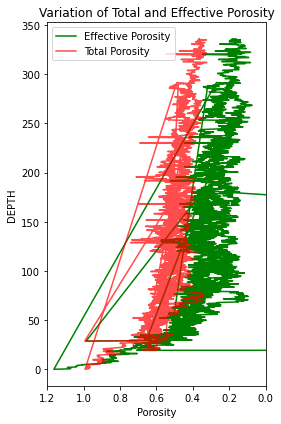

In [14]:
fig = plt.figure(figsize=(4,6))
ax1 = fig.add_subplot(111)
plt.title('Variation of Total and Effective Porosity')
ax1.plot(well_train["PHIECALC"], well_train["DEPTH"],  color = 'green', label='Effective Porosity')
ax1.plot(well_train["PHI"], well_train["DEPTH"],  color = 'red', alpha = 0.7, label='Total Porosity')
ax1.set_xlim(1.2, 0)
#ax1.xaxis.label.set_color("blue")


ax1.spines["top"].set_visible(True)

ax1.legend()
plt.xlabel('Porosity')
plt.ylabel('DEPTH')
plt.tight_layout()
plt.show()

For Prediction Wells

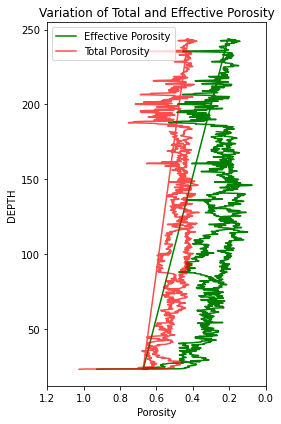

In [15]:
fig = plt.figure(figsize=(4,6))
ax1 = fig.add_subplot(111)
plt.title('Variation of Total and Effective Porosity')
ax1.plot(well_pred["PHIECALC"], well_pred["DEPTH"],  color = 'green', label='Effective Porosity')
ax1.plot(well_pred["PHI"], well_pred["DEPTH"],  color = 'red', alpha = 0.7, label='Total Porosity')
ax1.set_xlim(1.2, 0)
#ax1.xaxis.label.set_color("blue")


ax1.spines["top"].set_visible(True)

ax1.legend()
plt.xlabel('Porosity')
plt.ylabel('DEPTH')
plt.tight_layout()
plt.show()

In [14]:
well_train.replace(-999.25, np.nan, inplace=True)
well_pred.replace(-999.25, np.nan, inplace=True)

In [15]:
well_pred= well_pred.dropna()

In [16]:
well_train= well_train.dropna()

In [17]:
well_pred.isnull().sum()

GR          0
RHOB        0
Vsh         0
DT          0
PP          0
WELL        0
DEPTH       0
PHI         0
PHIECALC    0
dtype: int64

### Plotting the log plots

In [20]:
train_df=train_df.reset_index()

NameError: name 'train_df' is not defined

In [21]:
train_df.columns

NameError: name 'train_df' is not defined

For Training Well

In [55]:
pred_df= pred_df.reset_index()

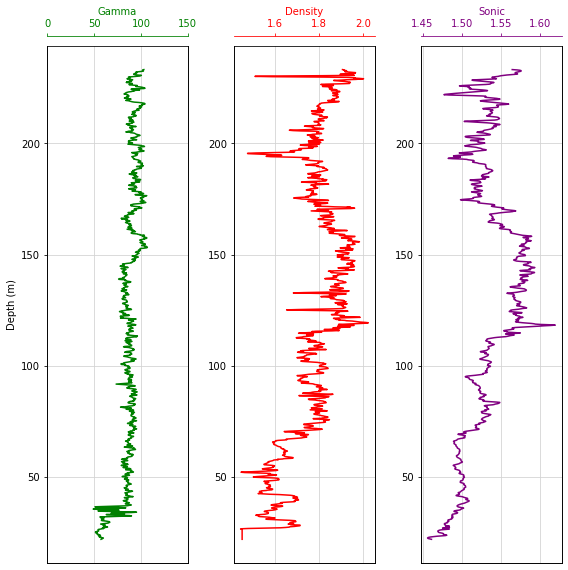

In [86]:
well= well1
fig, ax = plt.subplots(figsize=(8,8))

#Set up the plot axes
ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1)
ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1)


# As our curve scales will be detached from the top of the track,
# this code adds the top border back in without dealing with splines
ax7 = ax1.twiny()
ax7.xaxis.set_visible(False)
ax8 = ax2.twiny()
ax8.xaxis.set_visible(False)
ax9 = ax3.twiny()
ax9.xaxis.set_visible(False)

# Gamma Ray track
ax1.plot(well['GR'],well['DEPTH'],  color='green')
ax1.set_xlabel("Gamma")
ax1.xaxis.label.set_color("green")

ax1.set_ylabel("Depth (m)")
ax1.tick_params(axis='x', colors="green")
ax1.spines["top"].set_edgecolor("green")
ax1.title.set_color('green')
ax1.set_xticks([0, 50, 100, 150])

# Density track
ax2.plot(well["RHOB"], well["DEPTH"], color = "red")
ax2.set_xlabel("Density")
ax2.xaxis.label.set_color("red")
ax2.tick_params(axis='x', colors="red")
ax2.spines["top"].set_edgecolor("red")
#ax2.set_xticks([1.95,2.00, 2.4])

# Sonic track
ax3.plot(well["DT"],well["DEPTH"],  color = "purple")
ax3.set_xlabel("Sonic")

ax3.xaxis.label.set_color("purple")
ax3.tick_params(axis='x', colors="purple")
ax3.spines["top"].set_edgecolor("purple")


# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2, ax3]:
    
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", 1.02))
    
    
plt.tight_layout()

For Prediction Wells

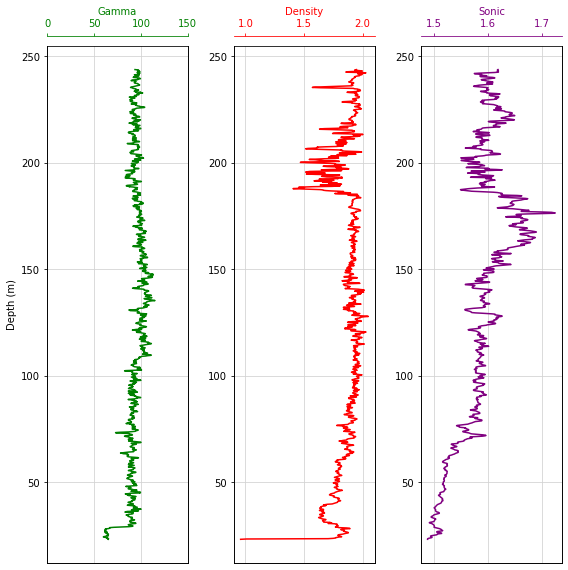

In [87]:
well= well7
fig, ax = plt.subplots(figsize=(8,8))

#Set up the plot axes
ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1)
ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1)


# As our curve scales will be detached from the top of the track,
# this code adds the top border back in without dealing with splines
ax7 = ax1.twiny()
ax7.xaxis.set_visible(False)
ax8 = ax2.twiny()
ax8.xaxis.set_visible(False)
ax9 = ax3.twiny()
ax9.xaxis.set_visible(False)

# Gamma Ray track
ax1.plot(well['GR'],well['DEPTH'],  color='green')
ax1.set_xlabel("Gamma")
ax1.xaxis.label.set_color("green")

ax1.set_ylabel("Depth (m)")
ax1.tick_params(axis='x', colors="green")
ax1.spines["top"].set_edgecolor("green")
ax1.title.set_color('green')
ax1.set_xticks([0, 50, 100, 150])

# Density track
ax2.plot(well["RHOB"],well["DEPTH"], color = "red")
ax2.set_xlabel("Density")
ax2.xaxis.label.set_color("red")
ax2.tick_params(axis='x', colors="red")
ax2.spines["top"].set_edgecolor("red")
#ax2.set_xticks([1.95,2.00, 2.4])

# Sonic track
ax3.plot(well["DT"],well["DEPTH"],  color = "purple")
ax3.set_xlabel("Sonic")

ax3.xaxis.label.set_color("purple")
ax3.tick_params(axis='x', colors="purple")
ax3.spines["top"].set_edgecolor("purple")


# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2, ax3]:
    
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", 1.02))
    
    
plt.tight_layout()

### Plotting Histograms and Crossplots

#### For Training Wells

In [21]:
cols_to_plot = list(train_df)
cols_to_plot.remove("DEPTH")

In [22]:
cols_to_plot

['index', 'GR', 'RHOB', 'DT', 'Vsh', 'Pore Pres']

Distribution Plots

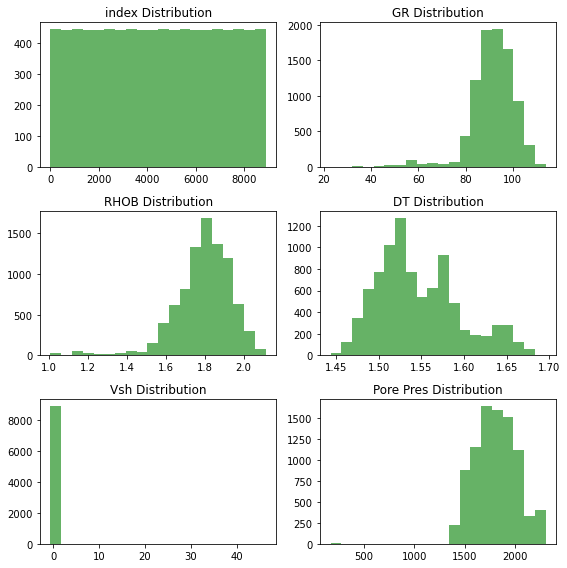

In [23]:
#Setup the number of rows and columns for our plot
rows = 3
cols = 2

fig=plt.figure(figsize=(8,8))

for i, feature in enumerate(cols_to_plot):
    ax=fig.add_subplot(rows,cols,i+1)
    train_df[feature].hist(bins=20,ax=ax,facecolor='green', alpha=0.6)
    ax.set_title(feature+" Distribution")
    ax.set_axisbelow(True)
    ax.grid(color='whitesmoke')

plt.tight_layout()  
plt.show()

Cross Plots

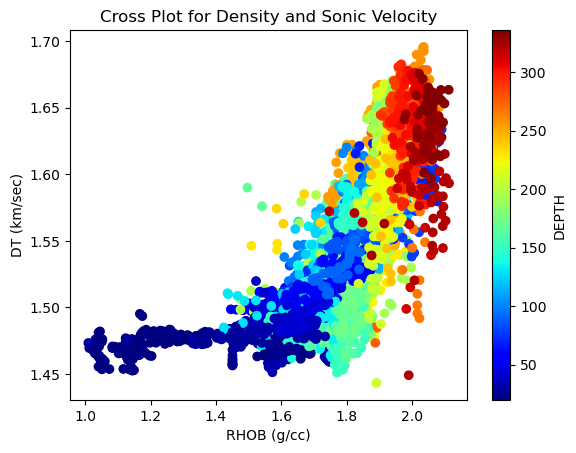

In [49]:
## Sonic Velocity Cross plot with Density

plt.style.use('default')
plt.scatter(x='RHOB', y='DT', data=train_df, c='DEPTH' , vmin=20, cmap='jet')
plt.xlabel("RHOB (g/cc)")
plt.ylabel("DT (km/sec)")
plt.title("Cross Plot for Density and Sonic Velocity")
plt.colorbar(label='DEPTH')
plt.show()

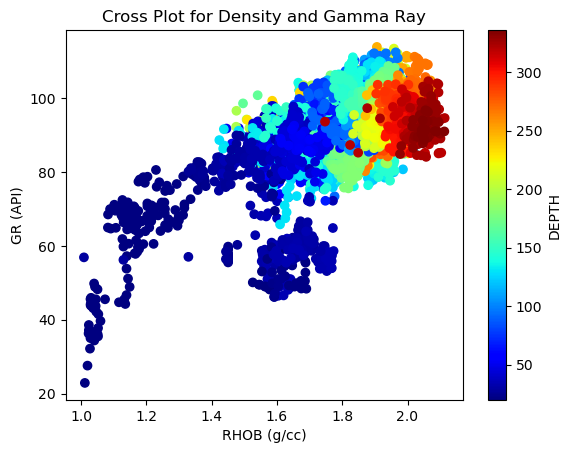

In [50]:
## GR Cross plot with density

plt.style.use('default')
plt.scatter(x='RHOB', y='GR', data=train_df, c='DEPTH' , vmin=20, cmap='jet')
plt.xlabel("RHOB (g/cc)")
plt.ylabel("GR (API)")
plt.title("Cross Plot for Density and Gamma Ray")
plt.colorbar(label='DEPTH')
plt.show()

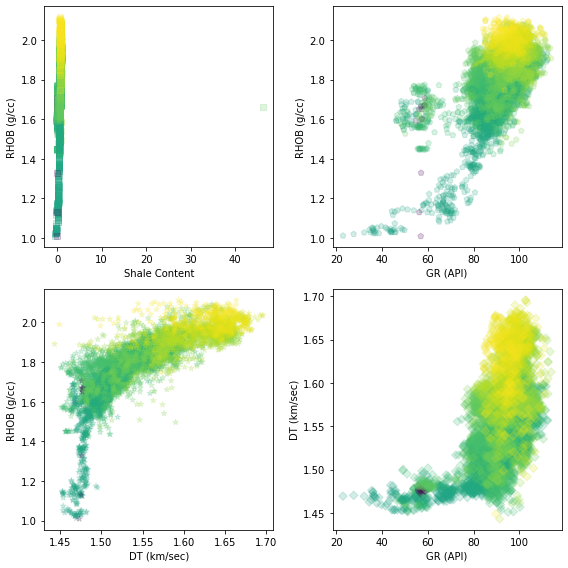

In [24]:
fig, ax = plt.subplots(figsize=(8,8))

ax1 = plt.subplot2grid((2,2), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((2,2), (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((2,2), (1,0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((2,2), (1,1), rowspan=1, colspan=1)

ax1.scatter(x= "Vsh", y= "RHOB",c="Pore Pres", data= train_df, marker="s",alpha= 0.2)

ax1.set_ylabel("RHOB (g/cc)")
ax1.set_xlabel("Shale Content")


ax2.scatter(x= "GR", y= "RHOB",c="Pore Pres", data= train_df, marker="p", alpha= 0.2)

ax2.set_ylabel("RHOB (g/cc)")
ax2.set_xlabel("GR (API)")

ax3.scatter(x= "DT", y= "RHOB",c="Pore Pres", data= train_df, marker="*", alpha= 0.2)

ax3.set_ylabel("RHOB (g/cc)")
ax3.set_xlabel("DT (km/sec)")

ax4.scatter(x= "GR", y= "DT",c="Pore Pres", data= train_df, marker="D", alpha= 0.2)
ax4.set_ylabel("DT (km/sec)")
ax4.set_xlabel("GR (API)")


plt.tight_layout()

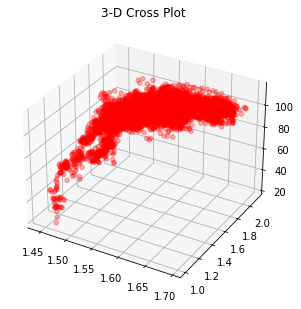

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
plt.title("3-D Cross Plot")
ax.scatter(train_df["DT"], train_df["RHOB"], train_df["GR"], alpha= 0.3, c="r")

#### For Prediction Wells

In [26]:
cols_to_plot = list(pred_df)
cols_to_plot.remove("DEPTH")

Distribution Plots

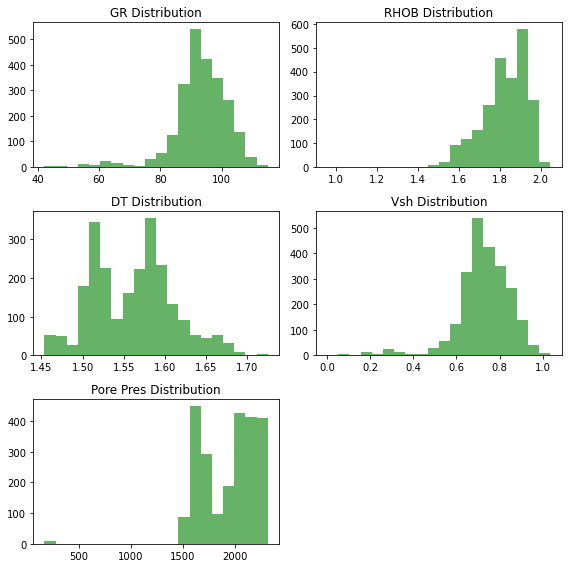

In [27]:
#Setup the number of rows and columns for our plot
rows = 3
cols = 2

fig=plt.figure(figsize=(8,8))

for i, feature in enumerate(cols_to_plot):
    ax=fig.add_subplot(rows,cols,i+1)
    pred_df[feature].hist(bins=20,ax=ax,facecolor='green', alpha=0.6)
    ax.set_title(feature+" Distribution")
    ax.set_axisbelow(True)
    ax.grid(color='whitesmoke')

plt.tight_layout()  
plt.show()

Cross Plots

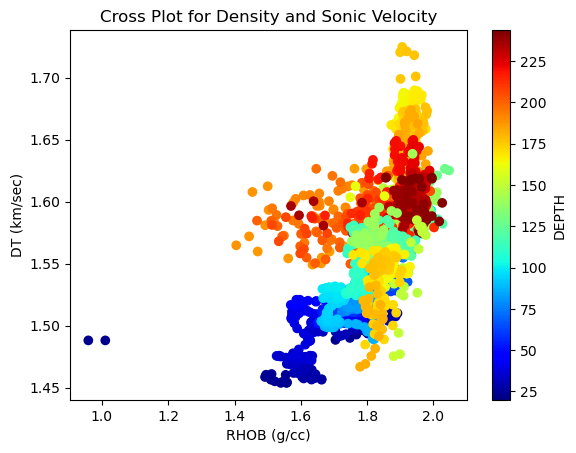

In [48]:
## Sonic Velocity Cross plot with Density

plt.style.use('default')
plt.scatter(x='RHOB', y='DT', data=pred_df, c='DEPTH' , vmin=20, cmap='jet')
plt.xlabel("RHOB (g/cc)")
plt.ylabel("DT (km/sec)")
plt.title("Cross Plot for Density and Sonic Velocity")
plt.colorbar(label='DEPTH')
plt.show()

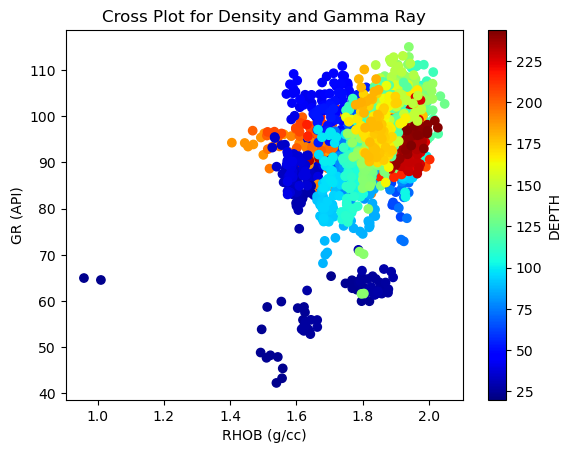

In [47]:
## GR Cross plot with density

plt.style.use('default')
plt.scatter(x='RHOB', y='GR', data=pred_df, c='DEPTH' , vmin=20, cmap='jet')
plt.xlabel("RHOB (g/cc)")
plt.ylabel("GR (API)")
plt.title("Cross Plot for Density and Gamma Ray")
plt.colorbar(label='DEPTH')
plt.show()


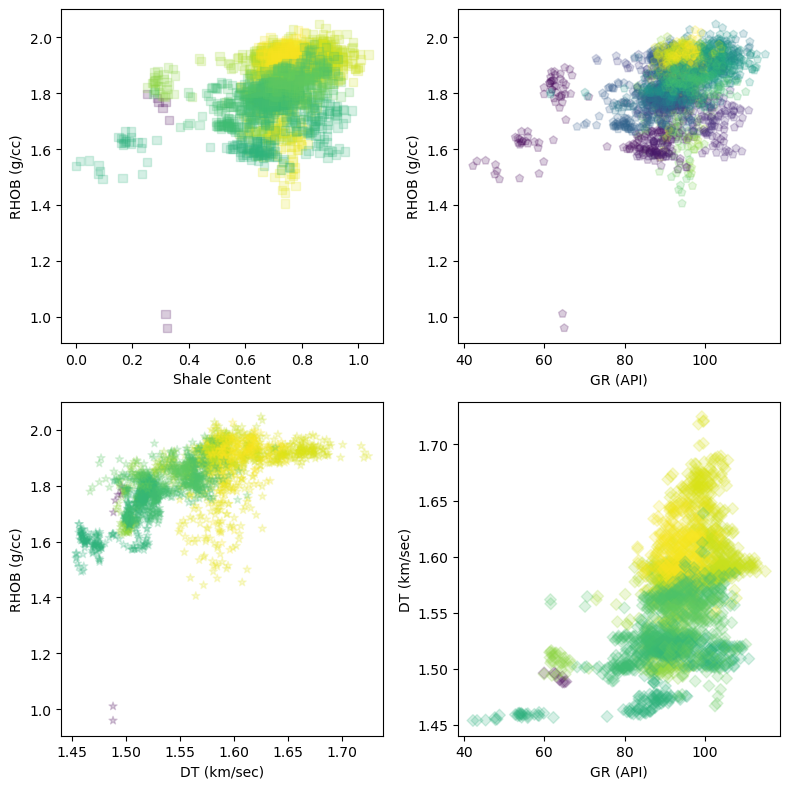

In [30]:
fig, ax = plt.subplots(figsize=(8,8))

ax1 = plt.subplot2grid((2,2), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((2,2), (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((2,2), (1,0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((2,2), (1,1), rowspan=1, colspan=1)

ax1.scatter(x= "Vsh", y= "RHOB",c="Pore Pres", data= pred_df, marker="s",alpha= 0.2)

ax1.set_ylabel("RHOB (g/cc)")
ax1.set_xlabel("Shale Content")


ax2.scatter(x= "GR", y= "RHOB",c="DEPTH", data= pred_df, marker="p", alpha= 0.2)

ax2.set_ylabel("RHOB (g/cc)")
ax2.set_xlabel("GR (API)")

ax3.scatter(x= "DT", y= "RHOB",c="Pore Pres", data= pred_df, marker="*", alpha= 0.2)

ax3.set_ylabel("RHOB (g/cc)")
ax3.set_xlabel("DT (km/sec)")

ax4.scatter(x= "GR", y= "DT",c="Pore Pres", data= pred_df, marker="D", alpha= 0.2)
ax4.set_ylabel("DT (km/sec)")
ax4.set_xlabel("GR (API)")


plt.tight_layout()

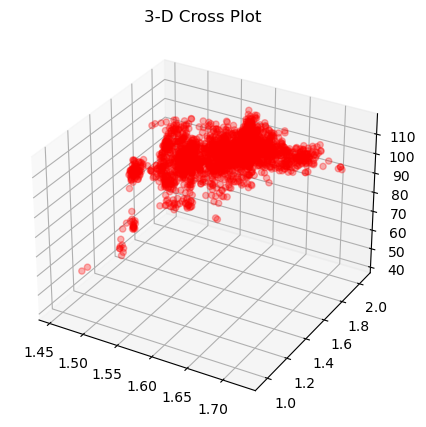

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
plt.title("3-D Cross Plot")
ax.scatter(pred_df["DT"], pred_df["RHOB"], pred_df["GR"], alpha= 0.3, c="r")

We can calculate differnt Petrophysical Properties for our data

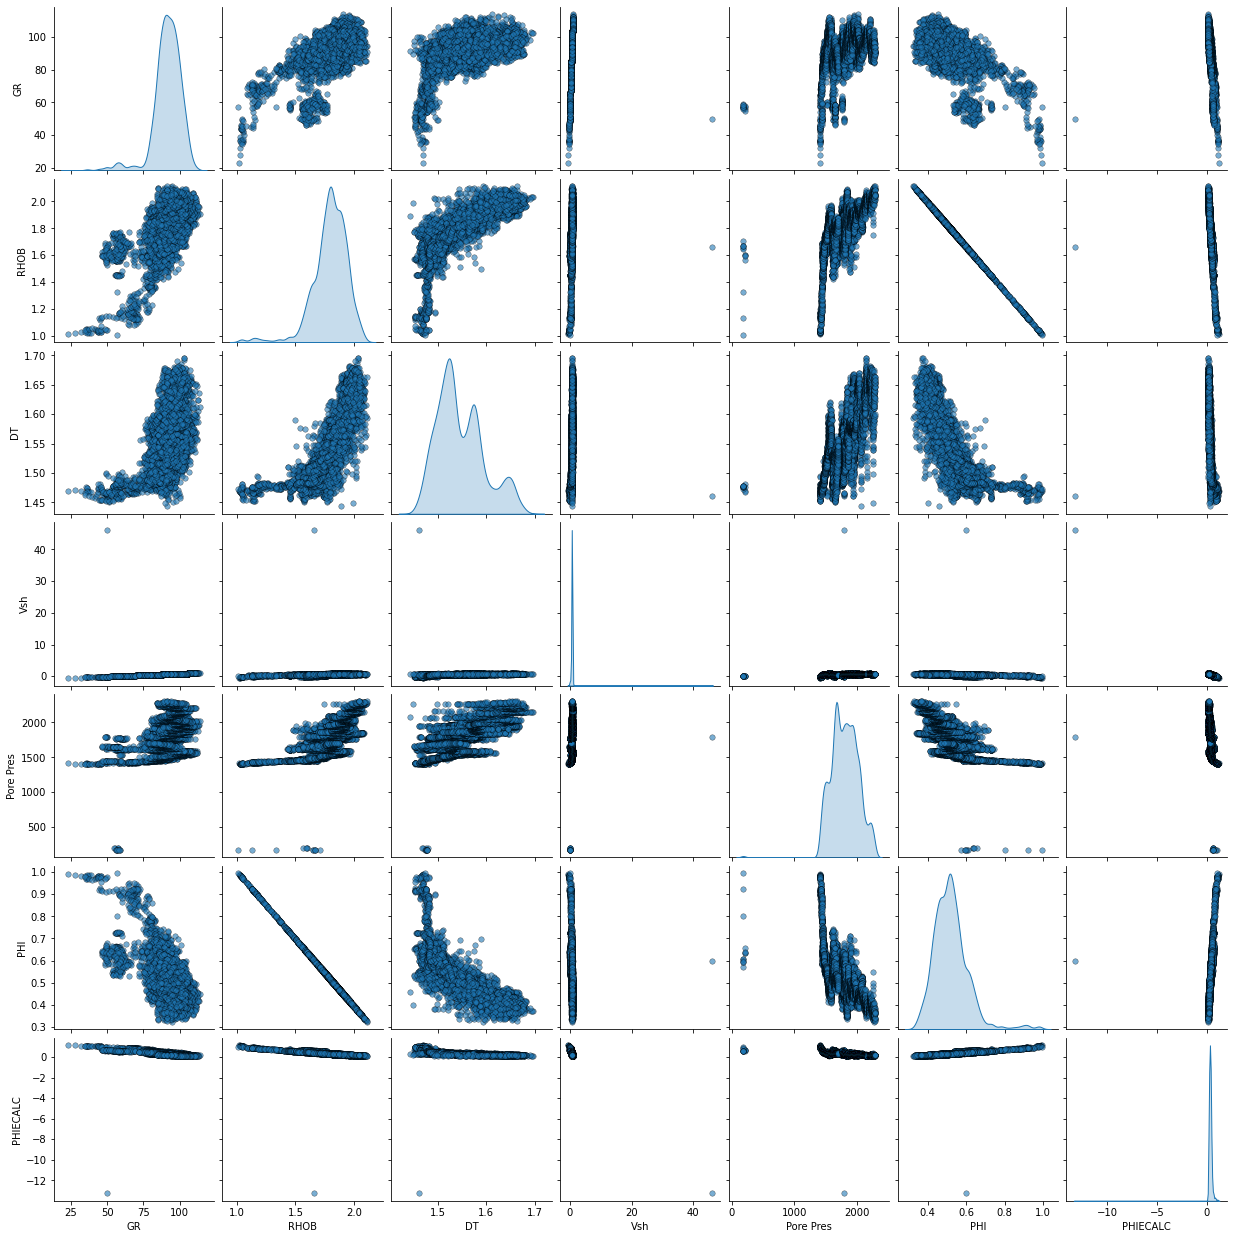

In [18]:
train_features = ['GR', 'RHOB', 'DT', 'Vsh', 'Pore Pres', 'PHI', 'PHIECALC']

sns.pairplot(train_df, vars=train_features, diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

Spearman's correlation heatmap

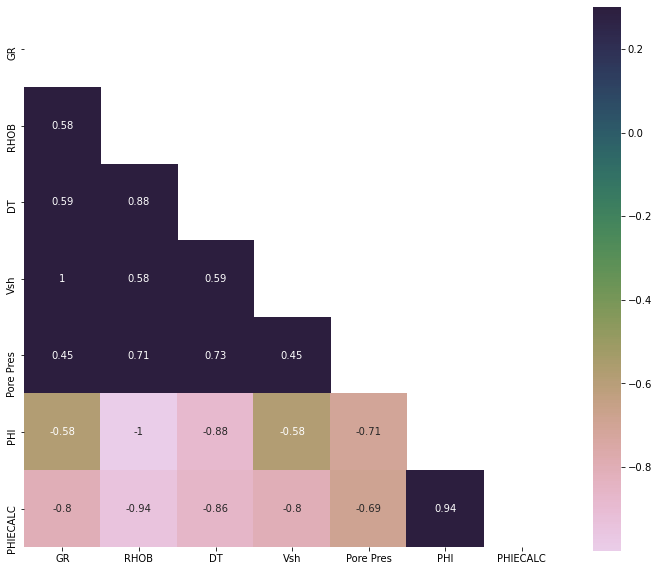

In [19]:
well_train_only_features = train_df[train_features]

# Generate a mask for the upper triangle
mask = np.zeros_like(well_train_only_features.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12,10))
sns.heatmap(well_train_only_features.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=.3, square=True)

plt.show()

### Normalization

Normalize the dataset:

Use power transform with Yeo-Johnson method

In [18]:
well_train= well_train[['GR', 'RHOB', 'Vsh', 'DT', 'PP', 'PHI', 'PHIECALC', 'WELL', 'DEPTH']]

In [19]:
colnames = well_train.columns
only_feature = ['GR', 'RHOB', 'DT', 'Vsh', 'PHI', 'PHIECALC'] # only feature column names
only_target = 'PP' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['GR', 'RHOB', 'Vsh', 'DT', 'PP', 'PHI', 'PHIECALC', 'WELL', 'DEPTH'], dtype='object')

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# normalize using power transform Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

## ColumnTransformer
#column_drop = ['WELL', 'DEPTH']
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

## fit and transform
well_train_norm = ct.fit_transform(well_train)

## convert to dataframe
well_train_norm = pd.DataFrame(well_train_norm, columns=colnames)
well_train_norm

GR      RHOB       Vsh        DT        PP       PHI  PHIECALC  \
0    -2.457207 -1.975686 -2.212083 -3.573476  1.956741  3.001854 -0.952072   
1    -2.438319 -1.975686 -2.283175 -3.490003  1.956741   2.97355 -0.952072   
2    -2.403656 -1.975686 -2.344283 -3.345468  1.956741  2.923946 -0.952072   
3    -2.400147 -1.975686 -2.380524 -3.331411  1.956741  2.919082 -0.952072   
4    -2.379694 -1.975686 -2.391439 -3.251422  1.956741  2.891263 -0.952072   
...        ...       ...       ...       ...       ...       ...       ...   
8884 -0.266692   2.25404  1.789682 -0.033823  -2.28925 -1.016736   2.49443   
8885 -0.444486  2.352236  1.769389 -0.172415 -2.395047  -0.99463  2.488895   
8886 -0.380604   2.31893  1.769389 -0.121498 -2.358108 -1.003297   2.51379   
8887 -0.151284  2.260134  1.833187  0.051227 -2.295669  -1.05196  2.516627   
8888  0.174293  2.300499   1.90072  0.273233 -2.338653 -1.152663  2.516627   

           WELL     DEPTH  
0     Well 1-2B   22.0024  
1     Well 1-2B   22.1548  
2     Well 1-2B   22.3072  
3     Well 1-2B   22.4596  
4     Well 1-2B    22.612  
...         ...       ...  
8884  Well 1-6A  335.2732  
8885  Well 1-6A  335.4256  
8886  Well 1-6A   335.578  
8887  Well 1-6A  335.7304  
8888  Well 1-6A  335.8828  

[8889 rows x 9 columns]

In [21]:
## Changing data types
x = well_train_norm[feature_target].astype(float)
y = well_train_norm['WELL'].astype(str)
z = well_train_norm['DEPTH'].astype(float)
well_train_norm = pd.concat([x, y, z], axis=1)

In [22]:
well_train_norm.head()

GR      RHOB        DT       Vsh       PHI  PHIECALC        PP  \
0 -2.457207 -1.975686 -3.573476 -2.212083  3.001854 -0.952072  1.956741   
1 -2.438319 -1.975686 -3.490003 -2.283175  2.973550 -0.952072  1.956741   
2 -2.403656 -1.975686 -3.345468 -2.344283  2.923946 -0.952072  1.956741   
3 -2.400147 -1.975686 -3.331411 -2.380524  2.919082 -0.952072  1.956741   
4 -2.379694 -1.975686 -3.251422 -2.391439  2.891263 -0.952072  1.956741   

        WELL    DEPTH  
0  Well 1-2B  22.0024  
1  Well 1-2B  22.1548  
2  Well 1-2B  22.3072  
3  Well 1-2B  22.4596  
4  Well 1-2B  22.6120

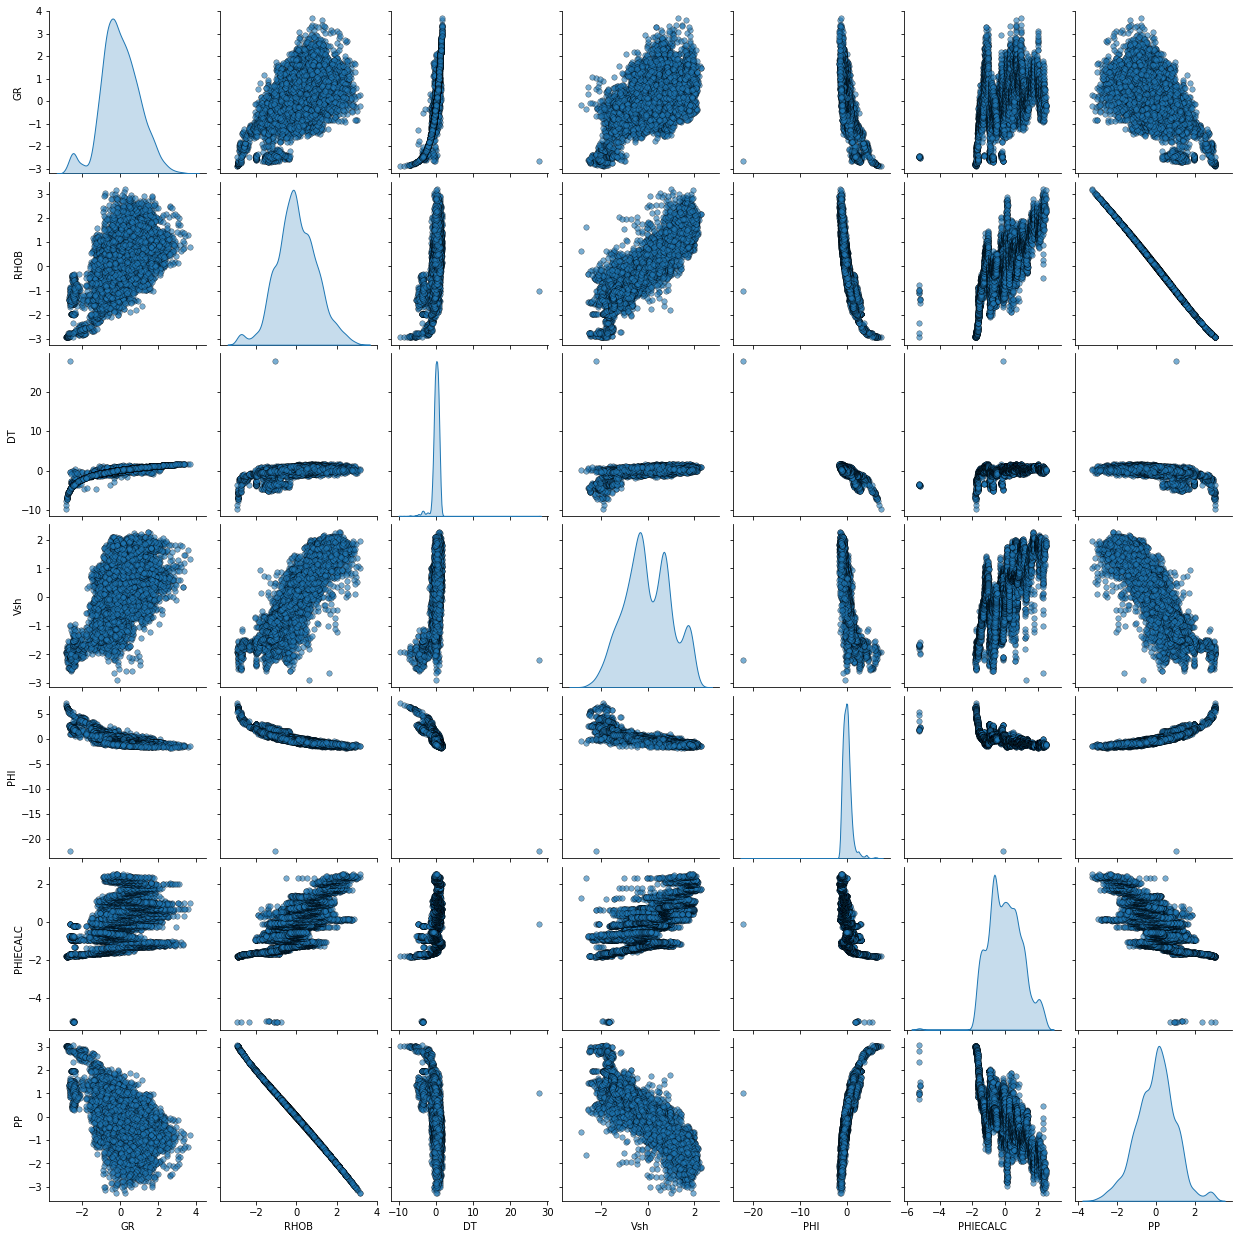

In [23]:
# x = well_train_norm[feature_target].astype(float)
sns.pairplot(well_train_norm, vars=feature_target, diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

### Outlier Analysis

Using Different Methods fo removing Outlier and then comparing which does the work best.

In [24]:
# make copy of well_train_norm, called well_train_dropped
well_train_drop = well_train_norm.copy()

# on the well_train_drop, drop WELL and DEPTH column
well_train_drop = well_train_norm.drop([ 'DEPTH'], axis=1)


In [25]:
well_train_drop = well_train_norm.drop(['WELL'], axis=1)

In [26]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Method 1: Standard Deviation Method (traditional)
well_train_std = well_train_drop[np.abs(well_train_drop - well_train_drop.mean()) <= (3 * well_train_drop.std())]

## delete all rows that have NaNs
well_train_std = well_train_std.dropna()

# Method 2: Isolation Forest
iso = IsolationForest(contamination=0.5)
yhat = iso.fit_predict(well_train_drop)
mask = yhat != -1
well_train_iso = well_train_norm[mask]

# Method 3: Minimum Covariance Determinant
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(well_train_drop)
mask = yhat != -1
well_train_ee = well_train_norm[mask]

# Method 4: Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.3)
yhat = lof.fit_predict(well_train_drop)
mask = yhat != -1
well_train_lof = well_train_norm[mask]

# Method 5: One-class SVM
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(well_train_drop)
mask = yhat != -1
well_train_svm = well_train_norm[mask]

Number of points before outliers removed                       : 8889
Number of points after outliers removed with Standard Deviation: 8532
Number of points after outliers removed with Isolation Forest  : 4445
Number of points after outliers removed with Min. Covariance   : 8000
Number of points after outliers removed with Outlier Factor    : 6222
Number of points after outliers removed with One-class SVM     : 8000


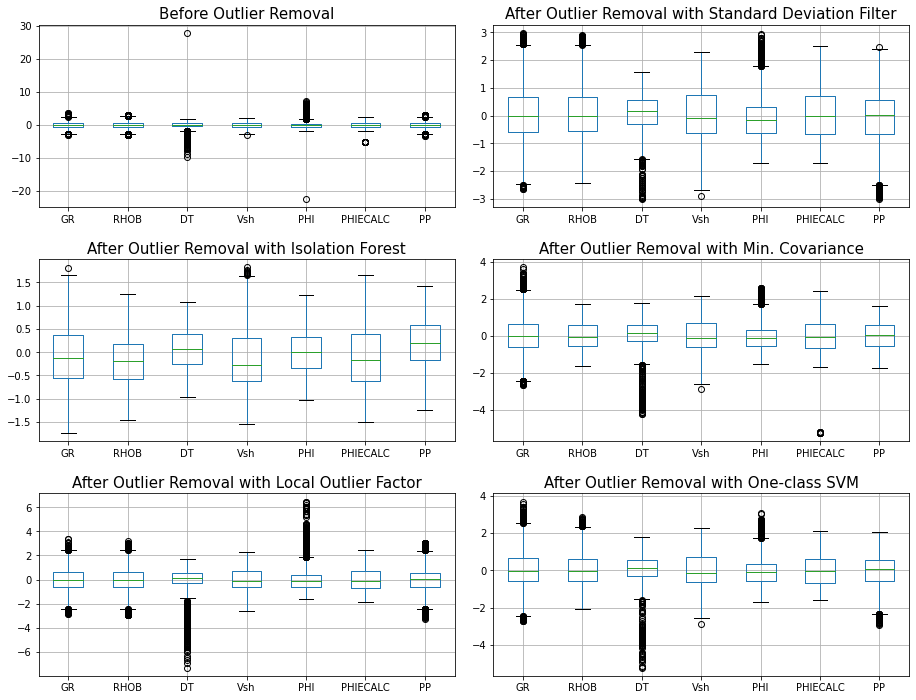

In [27]:
print('Number of points before outliers removed                       :', len(well_train_norm))
print('Number of points after outliers removed with Standard Deviation:', len(well_train_std))
print('Number of points after outliers removed with Isolation Forest  :', len(well_train_iso))
print('Number of points after outliers removed with Min. Covariance   :', len(well_train_ee))
print('Number of points after outliers removed with Outlier Factor    :', len(well_train_lof))
print('Number of points after outliers removed with One-class SVM     :', len(well_train_svm))

plt.figure(figsize=(13,10))

plt.subplot(3,2,1)
well_train_norm[feature_target].boxplot()
plt.title('Before Outlier Removal', size=15)

plt.subplot(3,2,2)
well_train_std[feature_target].boxplot()
plt.title('After Outlier Removal with Standard Deviation Filter', size=15)

plt.subplot(3,2,3)
well_train_iso[feature_target].boxplot()
plt.title('After Outlier Removal with Isolation Forest', size=15)

plt.subplot(3,2,4)
well_train_ee[feature_target].boxplot()
plt.title('After Outlier Removal with Min. Covariance', size=15)

plt.subplot(3,2,5)
well_train_lof[feature_target].boxplot()
plt.title('After Outlier Removal with Local Outlier Factor', size=15)

plt.subplot(3,2,6)
well_train_svm[feature_target].boxplot()
plt.title('After Outlier Removal with One-class SVM', size=15)

plt.tight_layout(1.7)
plt.show()

The best method we obtained is Isolation Forest, we will use this outlier removal method

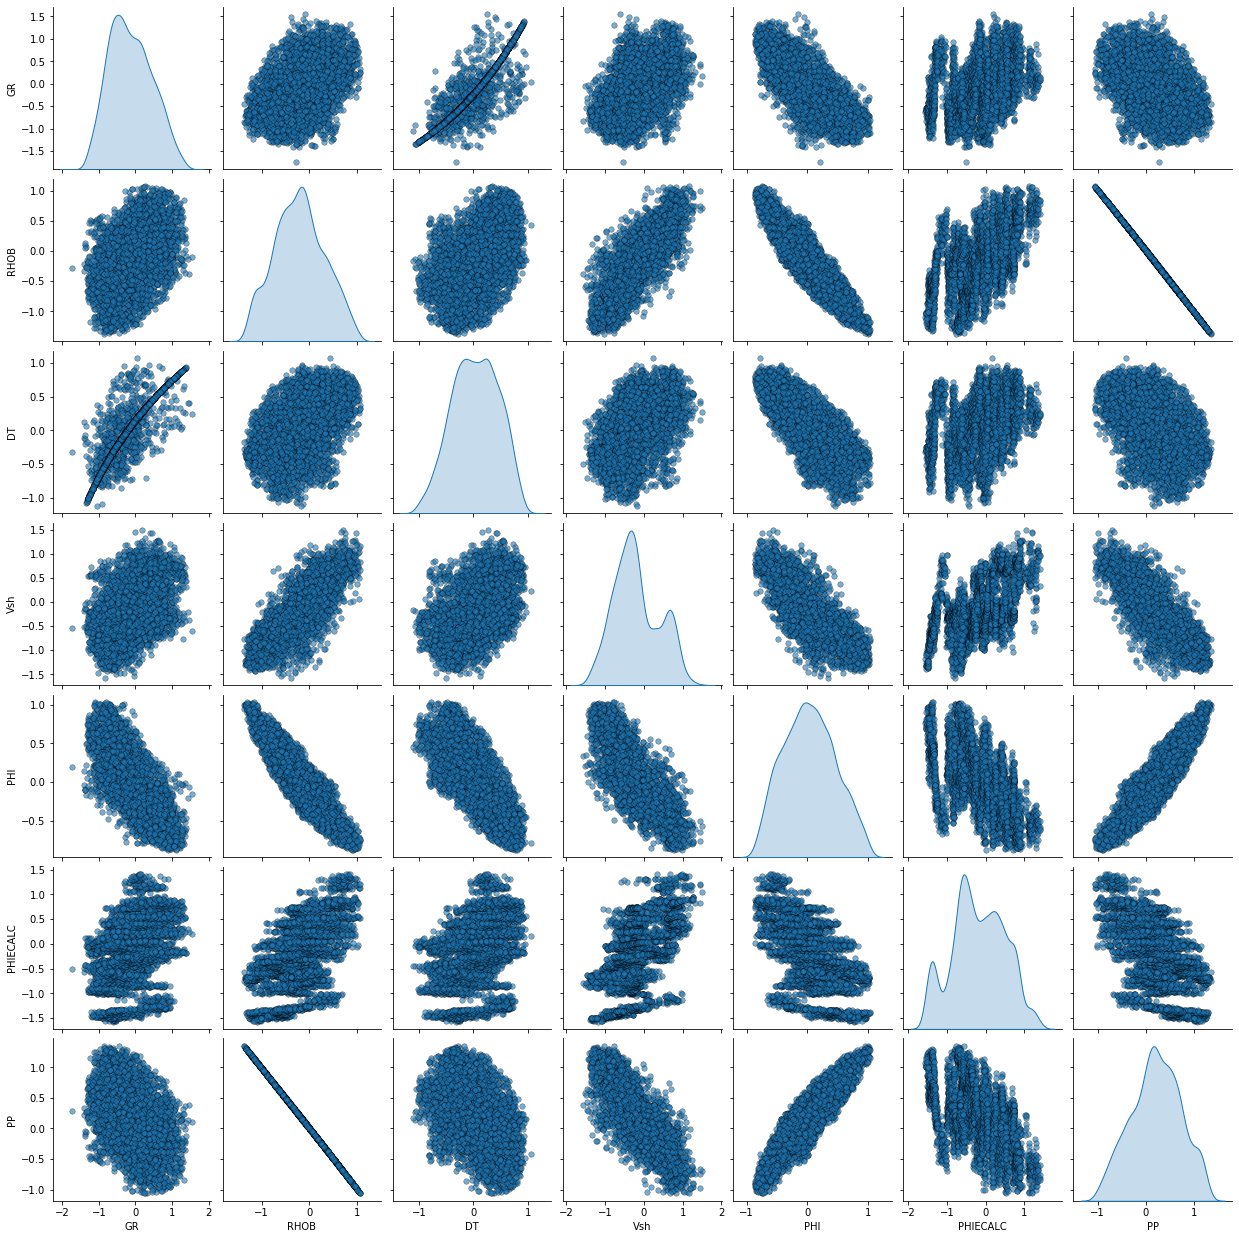

In [82]:
sns.pairplot(well_train_iso, vars=feature_target,
             diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

See how wonderfull our Data is looking after the outlier Removal and Normalisation

Density Plot

Text(0, 0.5, 'Density')

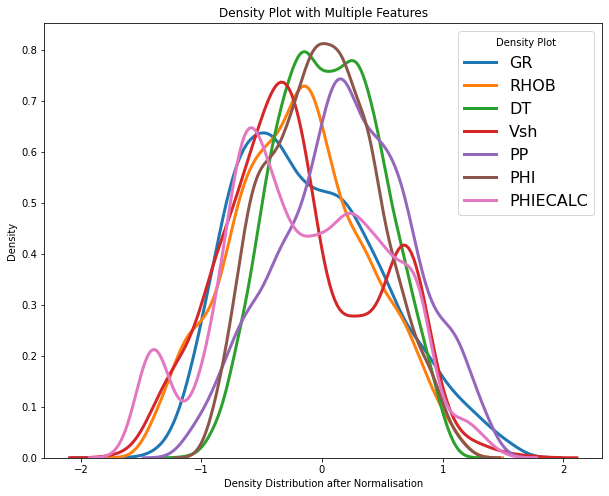

In [49]:
# List of five airlines to plot
plots = ['GR', 'RHOB', 'DT', 'Vsh', 'PP', 'PHI', 'PHIECALC']

# Iterate through the five airlines
plt.figure(figsize=(10,8))
for plot in plots:
    
    # Draw the density plot
    sns.distplot(well_train_iso[plot], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = plot)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Density Plot')
plt.title('Density Plot with Multiple Features')
plt.xlabel('Density Distribution after Normalisation')
plt.ylabel('Density')

## Model Development

Define the train data as the SVM outlier-removed-data

In [28]:
# Define the train data
feature = ['GR', 'RHOB', 'DT', 'Vsh',  'PHI', 'PHIECALC']
target = 'PP'

X_train = well_train_svm[only_feature].values
y_train = well_train_svm[only_target].values

Define the test data as the copy of normalized data (before outlier-removed)

In [29]:
# Define the test data 
well_pred1 = well_train_norm.copy()

names_train = ['Well 1-2B', 'Well 1-3A', 'Well 1-4A','Well 1-5A','Well 1-5B','Well 1-6A']

X_test = []
y_test = []
for i in range(len(names_train)):
  # split the df with respect to its name
  test = well_pred1.loc[well_pred1['WELL'] == names_train[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature) and y_test (target)
  X_test_, y_test_ = test[only_feature].values, test[only_target].values
  
  X_test.append(X_test_)
  y_test.append(y_test_)

# for each well 
X_test1, X_test2, X_test3, X_test4, X_test5, X_test6 = X_test
y_test1, y_test2, y_test3, y_test4, y_test5, y_test6  = y_test

Fit regression models to train data and predict to test data

In [33]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

# Create the regressor
model = GradientBoostingRegressor()
# print(model)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Predict on well 1
y_pred1 = model.predict(X_test1)
print("R-squared of Well 1: {}".format(model.score(X_test1, y_test1)))
rmse1 = r2_score(y_test1, y_pred1)
print("r2 _score of Well 1: {}".format(rmse1))

# Predict on well 2
y_pred2 = model.predict(X_test2)
print("R-squared of Well 2: {}".format(model.score(X_test2, y_test2)))
rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
print("r2 _score of Well 2: {}".format(rmse2))

# Predict on well 3
y_pred3 = model.predict(X_test3)
print("R-squared of Well 3: {}".format(model.score(X_test3, y_test3)))
rmse3 = np.sqrt(mean_squared_error(y_test3, y_pred3))
print("r2 _score of Well 3: {}".format(rmse3))

# Predict on well 4
y_pred4 = model.predict(X_test4)
print("R-squared of Well 4: {}".format(model.score(X_test4, y_test4)))
rmse4 = np.sqrt(mean_squared_error(y_test4, y_pred4))
print("r2 _score of Well 4: {}".format(rmse4))


# Predict on well 2
y_pred5 = model.predict(X_test5)
print("R-squared of Well 5: {}".format(model.score(X_test5, y_test5)))
rmse5 = np.sqrt(mean_squared_error(y_test5, y_pred5))
print("r2 _score of Well 5: {}".format(rmse5))

# Predict on well 6
y_pred6 = model.predict(X_test6)
print("R-squared of Well 6: {}".format(model.score(X_test6, y_test6)))
rmse6 = np.sqrt(mean_squared_error(y_test6, y_pred6))
print("r2 _score of Well 6: {}".format(rmse6))

R-squared of Well 1: 0.9999222893403311
r2 _score of Well 1: 0.9999222893403311
R-squared of Well 2: 0.9998949221294724
r2 _score of Well 2: 0.007186327990107542
R-squared of Well 3: 0.9998952058509598
r2 _score of Well 3: 0.007549418471426133
R-squared of Well 4: 0.9301345627346381
r2 _score of Well 4: 0.27285665428889055
R-squared of Well 5: 0.9998801461484929
r2 _score of Well 5: 0.007066966318711029
R-squared of Well 6: 0.9986115268750013
r2 _score of Well 6: 0.03541527478727995


In [32]:
from sklearn.metrics import r2_score


In [3]:
r2_list= ['rmse1','rmse2','rmse3','rmse4','rmse5','rmse6']
r2_mean= np.mean(r2_list)

NameError: name 'np' is not defined

In [ ]:
plt.annotate("r-squared = {:.3f}".format(r2_mean), (0, 1))

Denormalize the output

In [53]:
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_test1, y_pred1 = scaler.inverse_transform(y_test1.reshape(-1,1)), scaler.inverse_transform(y_pred1.reshape(-1,1))
y_test2, y_pred2 = scaler.inverse_transform(y_test2.reshape(-1,1)), scaler.inverse_transform(y_pred2.reshape(-1,1))
y_test3, y_pred3 = scaler.inverse_transform(y_test3.reshape(-1,1)), scaler.inverse_transform(y_pred3.reshape(-1,1))
y_test4, y_pred4 = scaler.inverse_transform(y_test4.reshape(-1,1)), scaler.inverse_transform(y_pred4.reshape(-1,1))
y_test5, y_pred5 = scaler.inverse_transform(y_test5.reshape(-1,1)), scaler.inverse_transform(y_pred5.reshape(-1,1))
y_test6, y_pred6 = scaler.inverse_transform(y_test6.reshape(-1,1)), scaler.inverse_transform(y_pred6.reshape(-1,1))

Compare the predicted DT with the true DT

0        19.1360
1        19.2884
2        19.4408
3        19.5932
4        19.7456
          ...   
1064    181.2896
1065    181.4420
1066    181.5944
1067    181.7468
1068    181.8992
Name: DEPTH, Length: 1069, dtype: float64

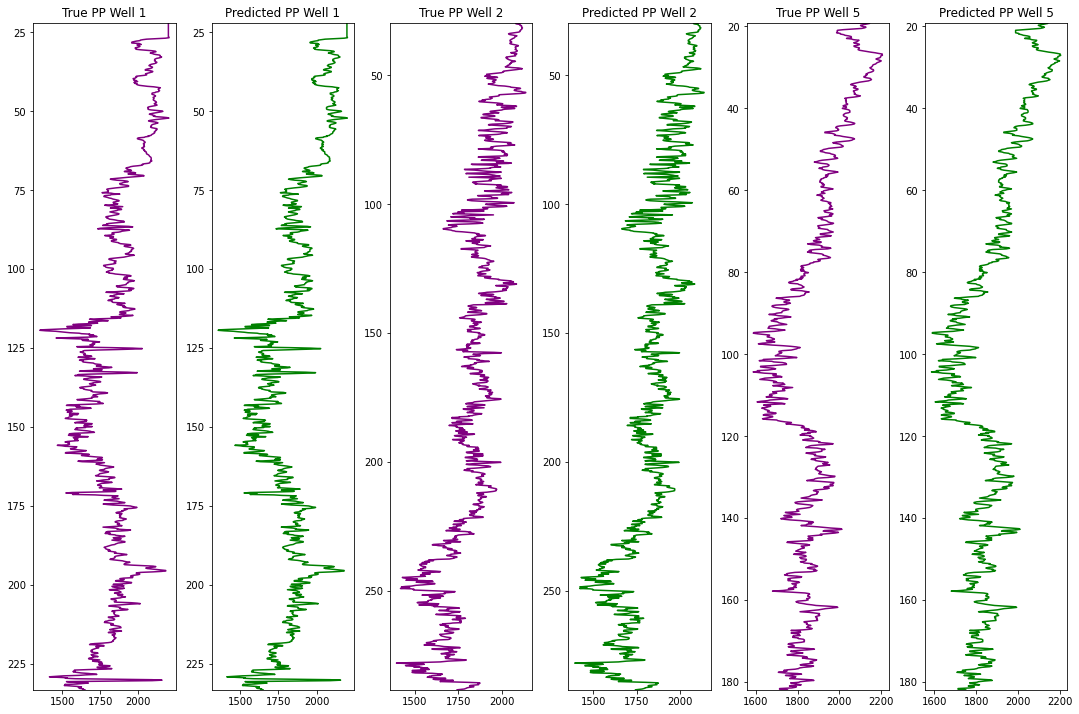

In [71]:
x = [y_test1, y_pred1,y_test2, y_pred2,  y_test5, y_pred5]
y = [well1['DEPTH'], well1['DEPTH'], well2['DEPTH'], well2['DEPTH'], well5['DEPTH'], well5['DEPTH']]

color = ['purple', 'green',  'purple', 'green', 'purple', 'green']
title = ['True PP Well 1', 'Predicted PP Well 1','True PP Well 2', 'Predicted PP Well 2',
         'True PP Well 5', 'Predicted PP Well 5']

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,10))

for i in range(len(x)):
    
    ax[i].plot(x[i], y[i], color=color[i])
    #ax[i].set_xlim(50, 150)
    ax[i].set_ylim(np.max(y[i]), np.min(y[i]))
    ax[i].set_title(title[i])

plt.tight_layout(1)

plt.show()

Use the Tuned Gradient Boosting for Final Prediction

In [72]:
X_train = well_train_svm[only_feature].values
y_train = well_train_svm[only_target].values

In [74]:
# Define the test data 
names_train = ['Well 1-7A','Well 1-11A']

X_test = []
y_test = []
depths = []
for i in range(len(names_train)):
  # split the df with respect to its name
  test = well_pred.loc[well_pred['WELL'] == names_train[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature)
  X_test_ = test[only_feature].values

  # define depth
  depth_ = test['DEPTH'].values
  
  X_test.append(X_test_)
  depths.append(depth_)

# for each well 2 and 5
X_test7, X_test8 = X_test
depth7, depth8 = depths

In [75]:
# Normalize X_test of well 2 and 5
X_test7 = scaler.fit_transform(X_test7)
X_test8 = scaler.fit_transform(X_test8)

# Predict to well 2 and 5
y_pred7 = model.predict(X_test7)
y_pred8 = model.predict(X_test8)

# Denormalize y_pred of well 2 and 5
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_pred7 = scaler.inverse_transform(y_pred7.reshape(-1,1))
y_pred8 = scaler.inverse_transform(y_pred8.reshape(-1,1))

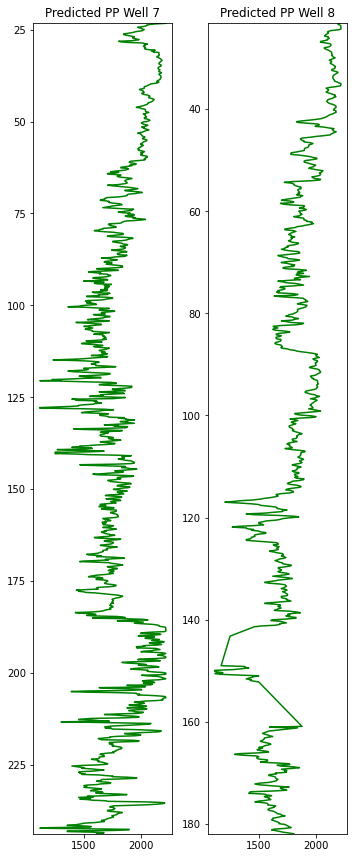

In [79]:
plt.figure(figsize=(5,12))

plt.subplot(1,2,1)
plt.plot(y_pred7, depth7, color='green')
plt.ylim(max(depth7), min(depth7))
plt.title('Predicted PP Well 7', size=12)

plt.subplot(1,2,2)
plt.plot(y_pred8, depth8, color='green')
plt.ylim(max(depth8), min(depth8))
plt.title('Predicted PP Well 8', size=12)

plt.tight_layout(1)
plt.show()